<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/Modelo_clasificacion_all_clases_tel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#cargamos libs
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import sys
import pandas
import glob
import re

# Clasificación todas las clases.
Vamos a hacerlo de varias formas:

1. De la misma forma que Rodrigo en su TFG.
2. Usando modelos preentrenados para clasificación.
  * Probar con diferentes modelos, algunos de clasificación de señales y así...
3. Crear modelo sencillo de predicción de energía para gamma y electrones. (ver si es factible)

In [ ]:
#usamos la funcion crear modelo que ha usado Rrodigo en su tfg

import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

def create_model(padding='same',stride=2,pool=2,filters=64,kernel=3,hidden_layers=2,neurons=20,optimizer='Adam',
                 learn_rate=0.001, init_mode='glorot_normal', activation='relu', dropout_rate=0.35,
                 weight_constraint=None,weight_regularizer=None, batchn=0,conv=2, n_filters=2,numClasses=7):#parameters here are default

    # initialize the model
    model = Sequential()                                                                       

    for i in range (conv):
        num=int(round(filters*(2**(i-1))))
        for i in range (n_filters):
              model.add(Conv2D(num, kernel, padding=padding,activation=activation,kernel_initializer=init_mode,kernel_constraint=weight_constraint,kernel_regularizer=weight_regularizer))
        model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))
        # model.add(Dropout(dropout_rate))
    # define the first FC => ACTIVATION layers
    model.add(Flatten())
    if (batchn==1):
        model.add(BatchNormalization())     
    model.add(Dropout(dropout_rate)) 
    for i in range(hidden_layers):
        model.add(Dense(neurons,kernel_initializer=init_mode,  activation=activation,kernel_regularizer=weight_regularizer)) 
        if (batchn==1):
            model.add(BatchNormalization())    #, use_bias=False
        model.add(Dropout(dropout_rate)) 
    # lastly, define the soft-max classifier
    model.add(Dense(numClasses, activation='softmax'))

    if (optimizer=='SGD'):
        optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    elif (optimizer=='RMS'):
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    elif (optimizer=='Adagrad'):
        optimizer=keras.optimizers.Adagrad(learning_rate=0.01)
    elif (optimizer=='Adadelta'):
        optimizer=keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
    elif (optimizer=='Adamax'):
        optimizer=keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Nadam'):
        optimizer=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Adam'):
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])              

    return model

* lo primero que tenemos que hacer es crear el data set para el entrenamiento
* vamos a cargar las imagenes de los elementos 
* despues vamos a crear para cada elemento una label
  * Vamos a hacer las labels con numeros (1,2,3,4,5,6) y la vamos a hacer con [0,0,0,1,0,0]...
* luego las vamos a sufflear rendom
* por ultimo vamos a separarlas en entrenamiento y en validation



# Cargamos los datos para 1 channel

In [ ]:
npy="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy_archivos_tel_1"

#cargamos los archivos y los metemos en una lista unos detras de otros
elements_npy=['gamma_8','gamma_9', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
#elements_npy=["electron","nitrogen","silicon","iron","proton","helium","gamma_0","gamma_1"]
elements=["electron","nitrogen","silicon","iron","proton","helium","gamma"]

In [ ]:
data=[]
for i in elements_npy:
  data.append(np.load(f"{npy}/{i}.npy"))



In [ ]:
data_new_2=np.concatenate([*data])
#data_new=np.concatenate((data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7]))

In [ ]:
print(data_new_2.shape)

(109677, 55, 93)


**Ahora vamos a poner las labels de dos formas**

In [ ]:
#forma 1
labels=[]
for i in range(len(data)):
  #esto esta mal porque la ultima debe ser igual que la penultima
  if i in (0,1):
    labels.append(0*np.ones(data[i].shape[0]))
  else:
    labels.append((i-1)*np.ones(data[i].shape[0]))

labels_new=np.concatenate([*labels])
print(labels_new.shape)

(109677,)


In [ ]:
labels

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2., 2., 2., ..., 2., 2., 2.]),
 array([3., 3., 3., ..., 3., 3., 3.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([5., 5., 5., ..., 5., 5., 5.]),
 array([6., 6., 6., ..., 6., 6., 6.])]

In [ ]:
#forma 2
#esta forma creo que se puede poner para que se genere de forma automatica mediante tensorflow
#se hace con keras.utils.to_categorical estamos convirtiendo las clases a matrices binarias

In [ ]:
#data_new=np.concatenate((data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7]))

In [ ]:
del labels, data

In [ ]:
#ahora creamos con los datos el data set
X_train, X_test, y_train, y_test = train_test_split(data_new_2, labels_new, test_size=0.33, random_state=42)

In [ ]:
del data_new_2, labels_new

In [ ]:

#vamos a darle una dimension mas a los datos, la batch
X_train=X_train[...,np.newaxis]
y_train=tf.keras.utils.to_categorical(y_train,7)
X_test=X_test[...,np.newaxis]
y_test=tf.keras.utils.to_categorical(y_test,7)

#1--Creamos el modelo y lo entrenamos

In [ ]:
#creamos el modelo
model=create_model()


In [ ]:
#creamos una call back para qeu pare si ya no mejora
no_mejora=keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)

In [ ]:

history=model.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])


Epoch 1/100
575/575 [==============================] - 91s 104ms/step - loss: 1.5055 - accuracy: 0.3926 - val_loss: 0.6172 - val_accuracy: 0.7778
Epoch 2/100
575/575 [==============================] - 56s 98ms/step - loss: 0.8687 - accuracy: 0.6715 - val_loss: 0.5717 - val_accuracy: 0.8214
Epoch 3/100
575/575 [==============================] - 57s 99ms/step - loss: 0.7677 - accuracy: 0.7057 - val_loss: 0.5252 - val_accuracy: 0.8066
Epoch 4/100
575/575 [==============================] - 57s 99ms/step - loss: 0.7039 - accuracy: 0.7351 - val_loss: 0.4790 - val_accuracy: 0.8293
Epoch 5/100
575/575 [==============================] - 57s 99ms/step - loss: 0.6715 - accuracy: 0.7494 - val_loss: 0.5074 - val_accuracy: 0.8194
Epoch 6/100
575/575 [==============================] - 56s 98ms/step - loss: 0.6575 - accuracy: 0.7532 - val_loss: 0.4742 - val_accuracy: 0.8336
Epoch 7/100
575/575 [==============================] - 56s 98ms/step - loss: 0.6431 - accuracy: 0.7609 - val_loss: 0.4596 - val_a

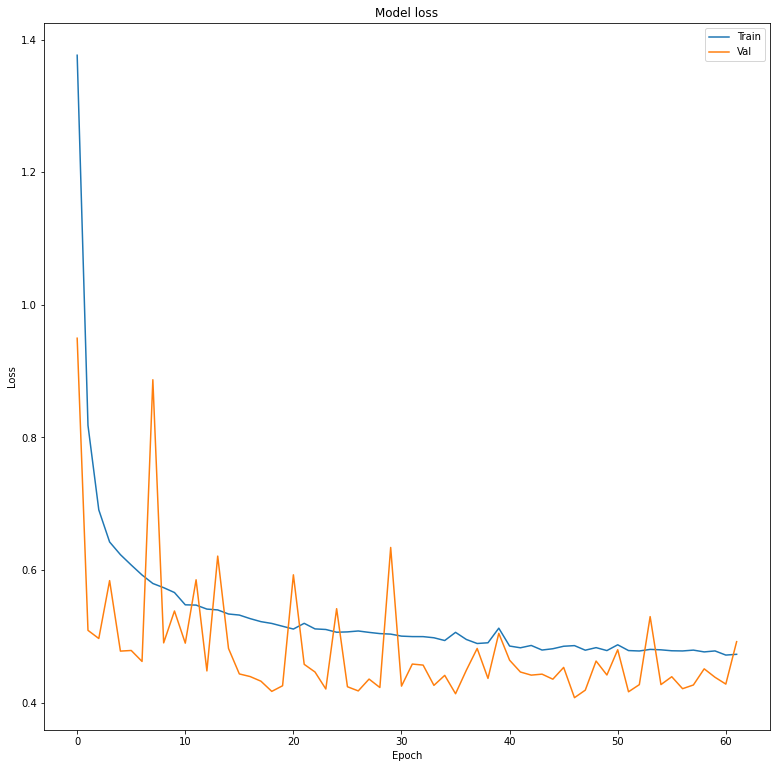

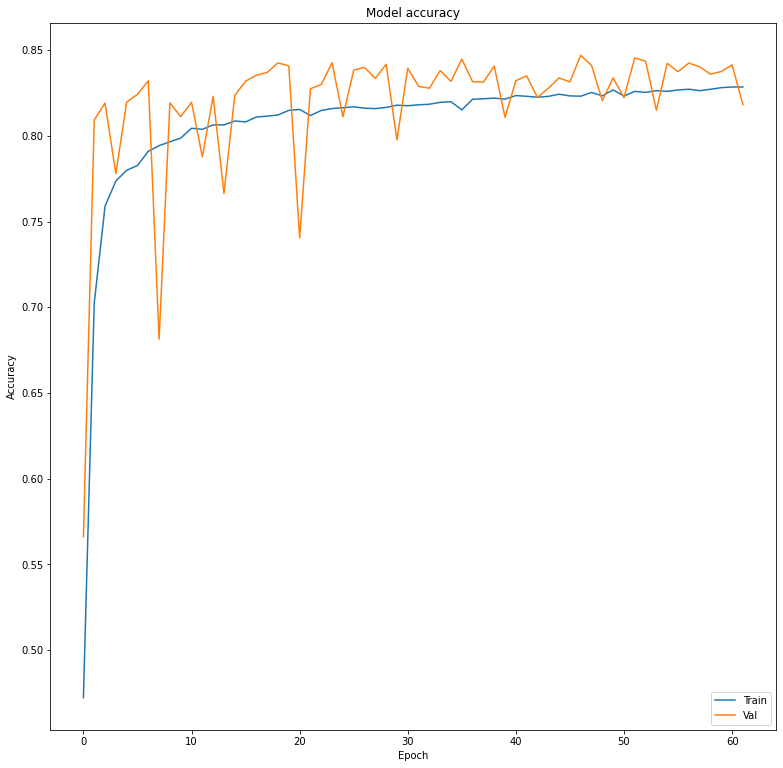

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
save_plot1=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/loss_2.png"
plt.savefig(save_plot1)
plt.figure(figsize=(13,13))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
save_plot2=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/accuracy_2.png"
plt.savefig(save_plot2)

In [ ]:
nombre_modelo="primer_modelo_2"
nombre_save=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/{nombre_modelo}.h5"
model.save(nombre_save)

# Intento con otra arquitectura mejor resultado:

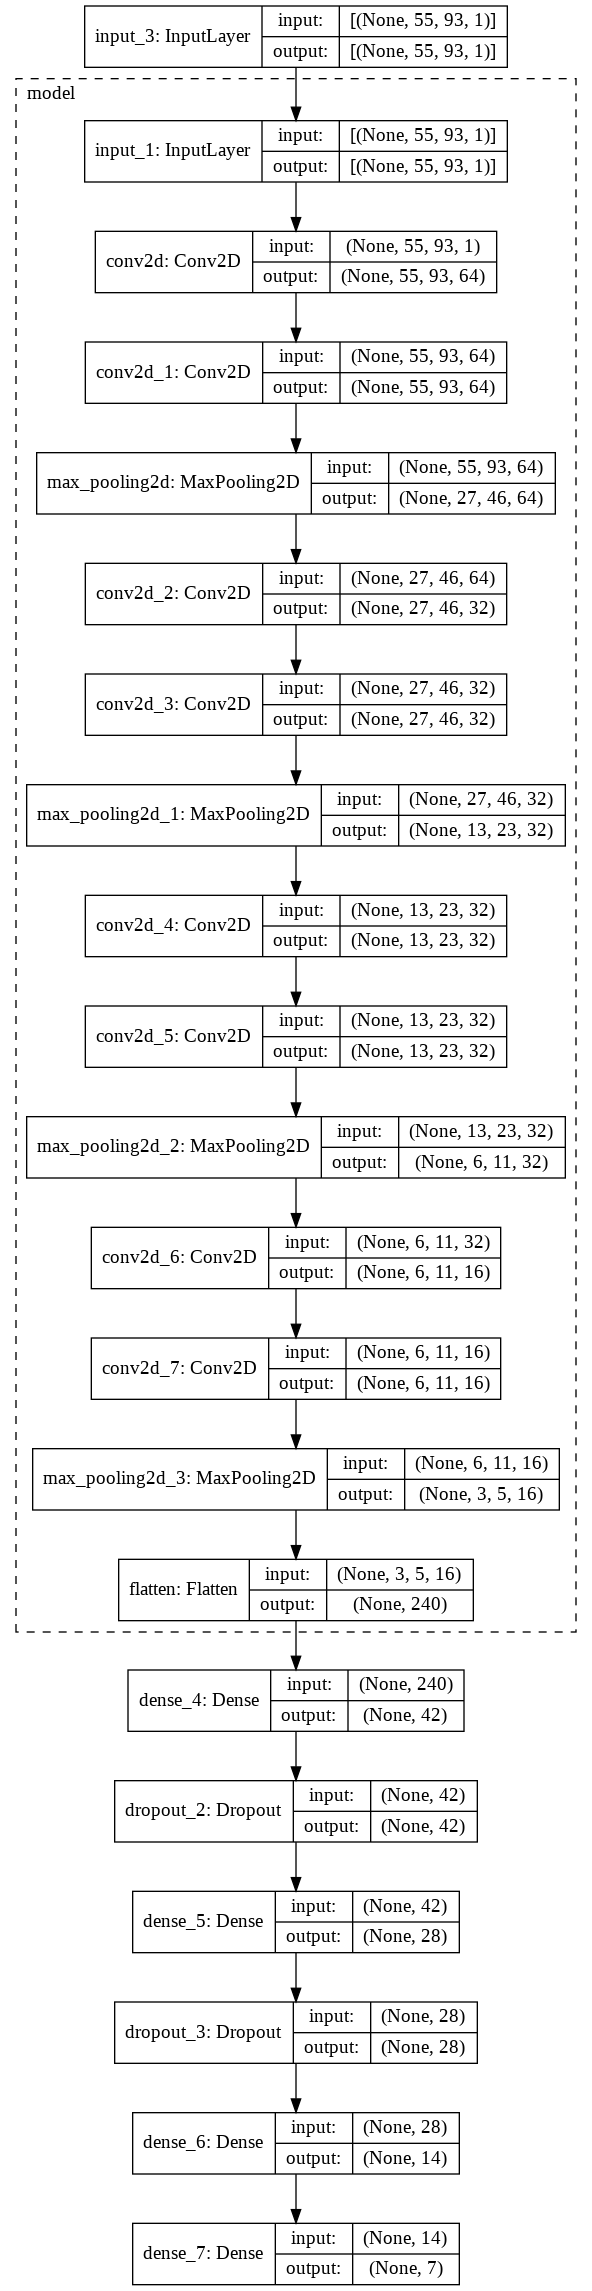

In [ ]:
model2=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/cuarto_solo1tels_acc_0988.h5")
tf.keras.utils.plot_model(model2, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
model2.summary()

Model: "prueba_red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 55, 93, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 240)               90720     
_________________________________________________________________
dense_4 (Dense)              (None, 42)                10122     
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 28)                1204      
_________________________________________________________________
dropout_3 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                4

In [ ]:
model2.evaluate(X_test,y_test)

1132/1132 [==============================] - 16s 14ms/step - loss: 6.2943 - accuracy: 0.5409


[6.294295787811279, 0.5409184098243713]

In [ ]:
model2.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])              
no_mejora=keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)

In [ ]:
history2=model2.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])

Epoch 1/100
575/575 [==============================] - 92s 155ms/step - loss: 1.0452 - accuracy: 0.7541 - val_loss: 0.4918 - val_accuracy: 0.8091
Epoch 2/100
575/575 [==============================] - 85s 148ms/step - loss: 0.5249 - accuracy: 0.8135 - val_loss: 0.4409 - val_accuracy: 0.8319
Epoch 3/100
575/575 [==============================] - 85s 148ms/step - loss: 0.4785 - accuracy: 0.8238 - val_loss: 0.4391 - val_accuracy: 0.8310
Epoch 4/100
575/575 [==============================] - 85s 148ms/step - loss: 0.4755 - accuracy: 0.8252 - val_loss: 0.4478 - val_accuracy: 0.8265
Epoch 5/100
575/575 [==============================] - 85s 148ms/step - loss: 0.4622 - accuracy: 0.8251 - val_loss: 0.4176 - val_accuracy: 0.8390
Epoch 6/100
575/575 [==============================] - 85s 148ms/step - loss: 0.4457 - accuracy: 0.8335 - val_loss: 0.4245 - val_accuracy: 0.8386
Epoch 7/100
575/575 [==============================] - 85s 148ms/step - loss: 0.4480 - accuracy: 0.8311 - val_loss: 0.4280 -

#2--Creamos modelo y lo entrenamos

Epoch 1/100
575/575 [==============================] - 37s 63ms/step - loss: 1.6896 - accuracy: 0.3322 - val_loss: 0.6672 - val_accuracy: 0.7112
Epoch 2/100
575/575 [==============================] - 36s 62ms/step - loss: 0.6797 - accuracy: 0.7459 - val_loss: 0.5872 - val_accuracy: 0.7767
Epoch 3/100
575/575 [==============================] - 36s 62ms/step - loss: 0.5598 - accuracy: 0.7981 - val_loss: 0.4546 - val_accuracy: 0.8368
Epoch 4/100
575/575 [==============================] - 36s 63ms/step - loss: 0.5230 - accuracy: 0.8108 - val_loss: 0.4266 - val_accuracy: 0.8403
Epoch 5/100
575/575 [==============================] - 37s 64ms/step - loss: 0.4949 - accuracy: 0.8213 - val_loss: 0.6658 - val_accuracy: 0.7199
Epoch 6/100
575/575 [==============================] - 37s 64ms/step - loss: 0.4847 - accuracy: 0.8228 - val_loss: 0.5700 - val_accuracy: 0.7887
Epoch 7/100
575/575 [==============================] - 37s 64ms/step - loss: 0.4755 - accuracy: 0.8238 - val_loss: 0.5483 - val_ac

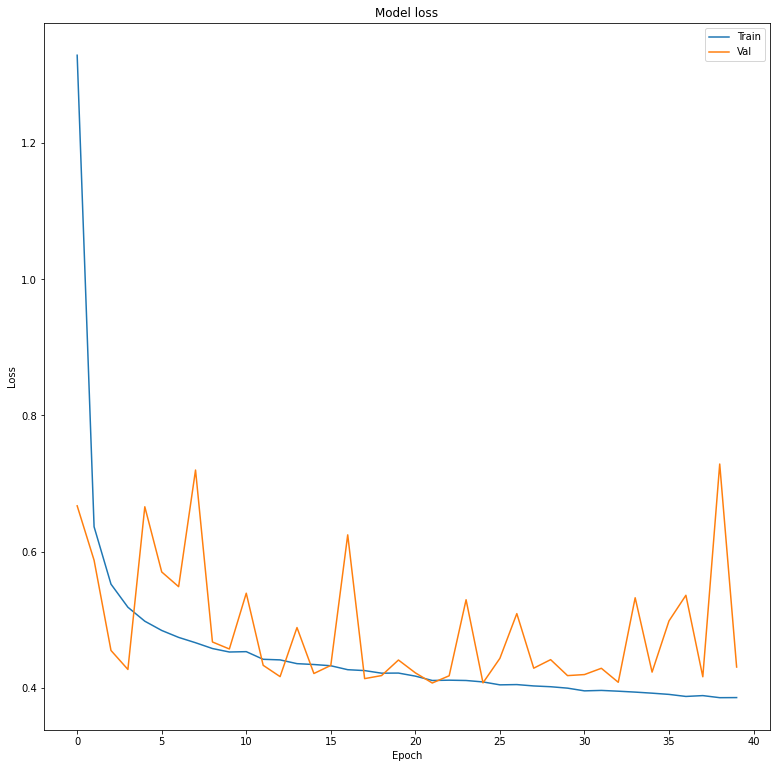

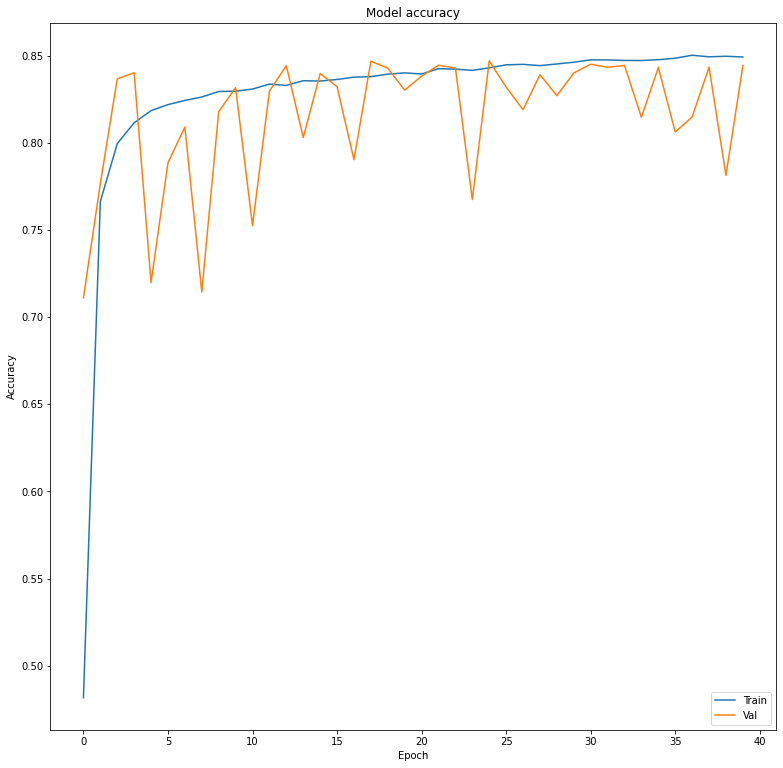

In [ ]:
model=create_model()
history=model.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])
plt.figure(figsize=(13,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
save_plot1=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/loss_3_dp_02.png"
plt.savefig(save_plot1)
plt.figure(figsize=(13,13))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
save_plot2=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/accuracy_3_dp_02.png"
plt.savefig(save_plot2)
nombre_modelo="primer_modelo_3"
nombre_save=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/{nombre_modelo}.h5"
model.save(nombre_save)

Epoch 1/100
575/575 [==============================] - 63s 52ms/step - loss: 1.7719 - accuracy: 0.2969 - val_loss: 0.9563 - val_accuracy: 0.6241
Epoch 2/100
575/575 [==============================] - 28s 49ms/step - loss: 0.8834 - accuracy: 0.6562 - val_loss: 0.5995 - val_accuracy: 0.7904
Epoch 3/100
575/575 [==============================] - 29s 50ms/step - loss: 0.7001 - accuracy: 0.7369 - val_loss: 0.6104 - val_accuracy: 0.7504
Epoch 4/100
575/575 [==============================] - 28s 50ms/step - loss: 0.6476 - accuracy: 0.7518 - val_loss: 0.4781 - val_accuracy: 0.8314
Epoch 5/100
575/575 [==============================] - 29s 50ms/step - loss: 0.6058 - accuracy: 0.7718 - val_loss: 0.6428 - val_accuracy: 0.7587
Epoch 6/100
575/575 [==============================] - 29s 50ms/step - loss: 0.5870 - accuracy: 0.7834 - val_loss: 0.5320 - val_accuracy: 0.7982
Epoch 7/100
575/575 [==============================] - 29s 50ms/step - loss: 0.5709 - accuracy: 0.7927 - val_loss: 0.4976 - val_ac

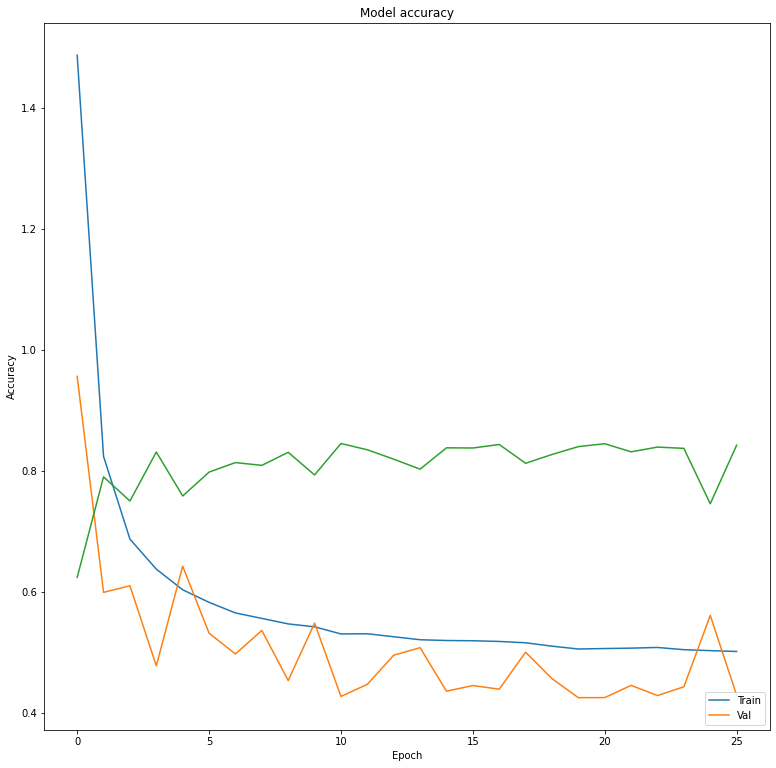

In [ ]:
model=create_model()
no_mejora=keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=15)
history=model.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])
plt.figure(figsize=(13,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
#save_plot1=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/loss_4_dp_02_adam.png"
#plt.savefig(save_plot1)
#plt.figure(figsize=(13,13))
#plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
#save_plot2=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/accuracy_4_dp_02_adam.png"
#plt.savefig(save_plot2)
#nombre_modelo="primer_modelo_4"
#nombre_save=f"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/{nombre_modelo}.h5"
#model.save(nombre_save)

# Clasificación usando los datos del año pasao (Rodri)

Epoch 1/100
145/145 [==============================] - 5s 29ms/step - loss: 1.3728 - accuracy: 0.4758 - val_loss: 0.8037 - val_accuracy: 0.6760
Epoch 2/100
145/145 [==============================] - 4s 28ms/step - loss: 0.8443 - accuracy: 0.6058 - val_loss: 0.6000 - val_accuracy: 0.6770
Epoch 3/100
145/145 [==============================] - 4s 28ms/step - loss: 0.7089 - accuracy: 0.6624 - val_loss: 0.5318 - val_accuracy: 0.8700
Epoch 4/100
145/145 [==============================] - 4s 28ms/step - loss: 0.6498 - accuracy: 0.7013 - val_loss: 0.4606 - val_accuracy: 0.7991
Epoch 5/100
145/145 [==============================] - 4s 29ms/step - loss: 0.5556 - accuracy: 0.7427 - val_loss: 0.3035 - val_accuracy: 0.8833
Epoch 6/100
145/145 [==============================] - 4s 28ms/step - loss: 0.4686 - accuracy: 0.7816 - val_loss: 0.3585 - val_accuracy: 0.8175
Epoch 7/100
145/145 [==============================] - 4s 28ms/step - loss: 0.4461 - accuracy: 0.8032 - val_loss: 0.2458 - val_accuracy:

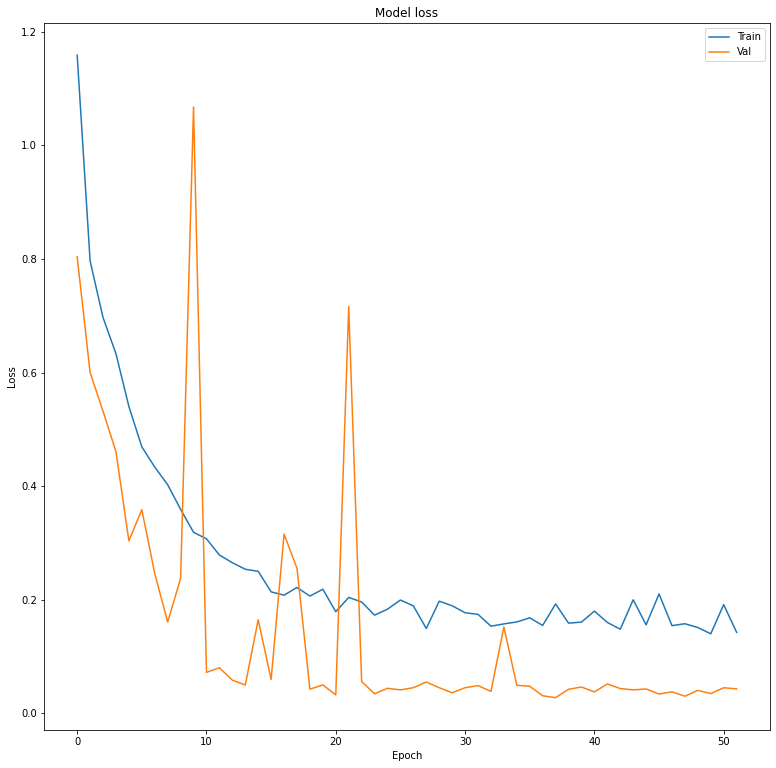

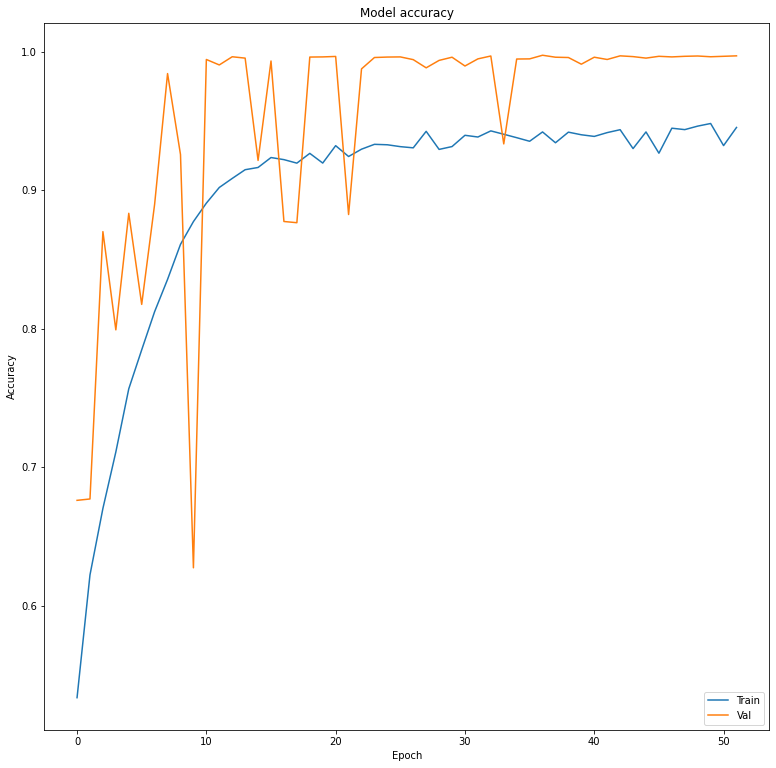

In [ ]:
#vamos a hacer todo esto igual pero para los datos de rodrigo a ver xq sale diferente
ruta_tfg_rodrigo="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/reconstruc_TFG_rodrigo"

elements=names=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']


aux_data=np.load(f"{ruta_tfg_rodrigo}/imagenes_dset.npy",allow_pickle=True)
num_of_gammas=aux_data[0].shape[0]//1
aux_data[0]=aux_data[0][0:(num_of_gammas)]

data_new_2=np.concatenate([*aux_data])

#forma 1
labels=[np.zeros(num_of_gammas)]
for i in range(1,len(aux_data)):
  labels.append(i*np.ones(aux_data[i].shape[0]))

labels_new=np.concatenate([*labels])
del labels, aux_data
X_train, X_test, y_train, y_test = train_test_split(data_new_2, labels_new, test_size=0.33, random_state=42)
del data_new_2, labels_new
X_train=X_train[...,np.newaxis]
y_train=y_train[...,np.newaxis]
X_test=X_test[...,np.newaxis]
y_test=y_test[...,np.newaxis]
model=create_model()
no_mejora=keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=15)
history=model.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])
plt.figure(figsize=(13,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.figure(figsize=(13,13))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
#guardamos el modelo de rodrigo
nombres_tfg_rod="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/modelo_rod_entrenado_datos_rodrigo_2.h5"
model.save(nombres_tfg_rod)

Hemos obtenido una precision de el 99% con el modelo de Rodrigo aplicado a los datos de rodrigo (un tecio de los gammas, son muchos), no se que porque a el le daba entorno al 70%.

Si lo entrenamos con la mitad de los Gammas disponibles tenemos problemas porque hay demasiados, obtenemos un 81% de precisión. Y no parece mejorar mucho mas.

Si lo entrenamos con el 100% de los gammas disponiblesm obtenemos un 99% de nuevo...

Vamos a probar a aplicar esos resultados, ese modelo a los datos actuales.

In [ ]:
#cargamos los datos actuales
try:
  del X_train, X_test, y_train, y_test
except:
  pass
nombres_tfg_rod="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/modelo_rod_entrenado_datos_rodrigo.h5"

npy="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy_archivos_tel_1"
#cargamos los archivos y los metemos en una lista unos detras de otros
elements_npy=['gamma_8','gamma_9', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
data=[]
for i in elements_npy:
  data.append(np.load(f"{npy}/{i}.npy"))
data_new_2=np.concatenate([*data])

#forma 1
labels=[]
for i in range(len(data)):
  #esto esta mal porque la ultima debe ser igual que la penultima
  if i ==1:
    labels.append((i-1)*np.ones(data[i].shape[0]))
  else:
    labels.append(i*np.ones(data[i].shape[0]))

labels_new=np.concatenate([*labels])
del labels, data
#ahora creamos con los datos el data set
X_train, X_test, y_train, y_test = train_test_split(data_new_2, labels_new, test_size=0.25, random_state=42)
del data_new_2, labels_new

#vamos a darle una dimension mas a los datos, la batch
X_train=X_train[...,np.newaxis]
y_train=y_train[...,np.newaxis]
X_test=X_test[...,np.newaxis]
y_test=y_test[...,np.newaxis]

In [ ]:
#nombres_tfg_rod="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/modelo_rod_entrenado_datos_rodrigo.h5"

model=tf.keras.models.load_model("/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/modelo_rod_entrenado_datos_rodrigo.h5")
#model=create_model()
no_mejora=keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=15)
history=model.fit(X_train, y_train, epochs=100,batch_size=128, validation_data=(X_test, y_test),callbacks=[no_mejora])
plt.figure(figsize=(13,13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.figure(figsize=(13,13))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
model.evaluate(X_test,y_test)
model_tfg_rod_finetun="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/modelo_rod_entrenado_datos_arturo.h5"
model.save(model_tfg_rod_finetun)

Epoch 1/100
575/575 [==============================] - 17s 28ms/step - loss: 1.3931 - accuracy: 0.4945 - val_loss: 0.9001 - val_accuracy: 0.5758
Epoch 2/100
575/575 [==============================] - 16s 28ms/step - loss: 1.0345 - accuracy: 0.5884 - val_loss: 0.7596 - val_accuracy: 0.6959
Epoch 3/100
575/575 [==============================] - 16s 28ms/step - loss: 0.9861 - accuracy: 0.6065 - val_loss: 0.7437 - val_accuracy: 0.7581
Epoch 4/100
575/575 [==============================] - 16s 28ms/step - loss: 0.9390 - accuracy: 0.6380 - val_loss: 0.6589 - val_accuracy: 0.7464
Epoch 5/100
575/575 [==============================] - 16s 28ms/step - loss: 0.7808 - accuracy: 0.7122 - val_loss: 0.5093 - val_accuracy: 0.8182
Epoch 6/100
575/575 [==============================] - 16s 28ms/step - loss: 0.7264 - accuracy: 0.7403 - val_loss: 0.4919 - val_accuracy: 0.8275
Epoch 7/100
575/575 [==============================] - 16s 28ms/step - loss: 0.6800 - accuracy: 0.7584 - val_loss: 0.5021 - val_ac

KeyboardInterrupt: ignored

In [ ]:
#ahora, por ultimo vamos a intentar hacer transfer learning, a ver si podemos mejorar los 84% acc que obtenemos en nuetros datos
#mejorar los 99% del modelo en los datos de Rod esta complicao
#queda pendiente

# 3-- Transfer learning:

Vamos a usar un modelo preentrenador en imagenet para que nos prediga las categorias

## Primero debemos que cargar los datos de una manera especial (3-channels)

In [ ]:
del X_train, X_test, y_train, y_test

In [ ]:
npy="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy_archivos_tel_1"

#cargamos los archivos y los metemos en una lista unos detras de otros
elements_npy=['gamma_8', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
#elements_npy=["electron","nitrogen","silicon","iron","proton","helium","gamma_0","gamma_1"]
elements=["electron","nitrogen","silicon","iron","proton","helium","gamma"]

In [ ]:
data=np.load(f"{npy}/{elements_npy[0]}.npy")
index=(data.shape[0])//3
inicio=index
data=data[inicio:(index+inicio)]
data=np.stack((data,)*3,axis=-1)
labels=np.zeros(index)
for j,i in enumerate(elements_npy[1:]):
    print(i)
    aux_dat=np.load(f"{npy}/{i}.npy")
    index=(aux_dat.shape[0])//3
    aux_dat=aux_dat[inicio:(index+inicio)]
    aux_dat=np.stack((aux_dat,)*3,axis=-1)
    data=np.concatenate((data,aux_dat))
    print(data.shape)
    del aux_dat
    labels=np.concatenate((labels, (j+1)*np.ones(index)))

labels.astype("int")


electron
(5062, 55, 93, 3)
proton
(14115, 55, 93, 3)
helium
(20717, 55, 93, 3)
iron
(25581, 55, 93, 3)
nitrogen
(29231, 55, 93, 3)
silicon
(34113, 55, 93, 3)


array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
half_max_value_ints=(np.amax(data[:,:,:,0]))/2

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
#ahora creamos con los datos el data set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=7)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=7)

In [ ]:
del data,labels

In [ ]:
y_test

array([3., 6., 3., ..., 6., 2., 2.])

## Luego debemos cargar el modelo y compilar

In [ ]:
modelo_cargado=tf.keras.applications.MobileNet(include_top=False,input_shape=(55,93,3))

In [ ]:
modelo_cargado.summary()

In [ ]:
modelo_cargado.trainable=False

In [ ]:
#creamos el modelo añadiendo unas cuantas redes densas al final
#es importante darle al modelo un imput que le resulte familiar y tal, por ello tenemos que normalizar el input
# lo normal parece ser que vaya de [0,255] a [-1,+1]
#nuestros datos son intensidades entonces lo que vamos a hacer es buscar el máximo valor

#esto lo estoy copiando talcual de la documentacion
inputs = tf.keras.Input(shape=(55, 93, 3))
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([half_max_value_ints] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])
x = modelo_cargado(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(200,activation="relu")(x)
x = tf.keras.layers.Dense(50,activation="relu")(x)
outputs=tf.keras.layers.Dense(7,activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 55, 93, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 55, 93, 3)         7         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1, 2, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               205000    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050 

In [ ]:
X_train.shape

(27290, 55, 93, 3)

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']) 

In [ ]:
history=model.fit(X_train,y_train,epochs=100,batch_size=64,validation_data=(X_test,y_test),callbacks=[stop])

Epoch 1/100
427/427 [==============================] - 41s 17ms/step - loss: 1.5852 - accuracy: 0.3792 - val_loss: 1.1857 - val_accuracy: 0.5561
Epoch 2/100
427/427 [==============================] - 6s 13ms/step - loss: 1.3437 - accuracy: 0.4768 - val_loss: 1.2386 - val_accuracy: 0.4996
Epoch 3/100
427/427 [==============================] - 6s 13ms/step - loss: 1.3154 - accuracy: 0.4995 - val_loss: 1.2493 - val_accuracy: 0.4985
Epoch 4/100
427/427 [==============================] - 6s 13ms/step - loss: 1.2926 - accuracy: 0.5044 - val_loss: 1.2718 - val_accuracy: 0.5086
Epoch 5/100
427/427 [==============================] - 6s 13ms/step - loss: 1.2825 - accuracy: 0.5102 - val_loss: 1.2562 - val_accuracy: 0.5010
Epoch 6/100
427/427 [==============================] - 6s 13ms/step - loss: 1.2764 - accuracy: 0.5120 - val_loss: 1.2828 - val_accuracy: 0.4958
Epoch 7/100
427/427 [==============================] - 6s 13ms/step - loss: 1.2655 - accuracy: 0.5143 - val_loss: 1.2417 - val_accuracy

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
del _,_4

In [ ]:
modelo_cargado.trainable=True
model.save("/content/drive/MyDrive/tranf_learning_provisional2.h5")

In [ ]:
model= tf.keras.models.load_model("/content/drive/MyDrive/tranf_learning_provisional2.h5")

In [ ]:
#ahora hacemos el finetuning
#modelo_cargado.trainable=True
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)

history=model.fit(X_train,y_train,epochs=100,batch_size=64,validation_data=(X_test,y_test),callbacks=[stop])

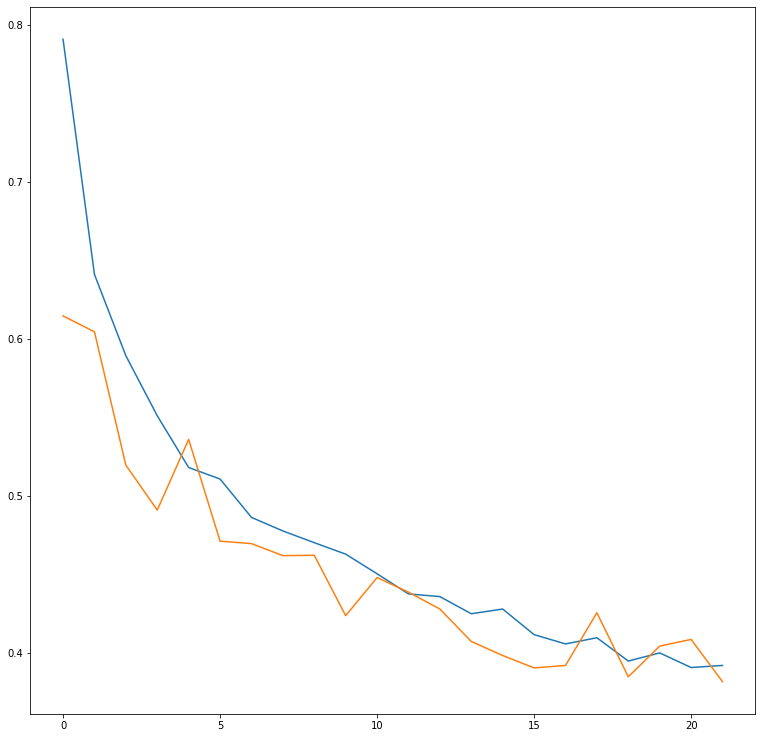

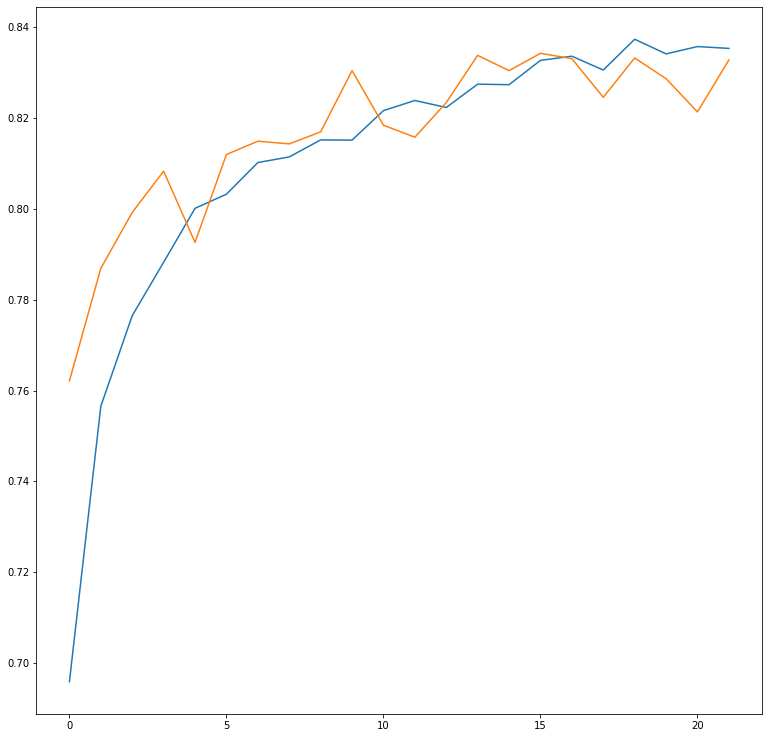

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.figure(figsize=(13,13))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
model.save("/content/drive/MyDrive/tranf_learning_provisional2.h5")

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 55, 93, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 55, 93, 3)         7         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 3, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               166500    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707   